# **Predicting Student Dropout Risk and Optimizing Educational Resources**

# Load Dataset

In [2]:
from google.colab import files

uploaded = files.upload()  # Click "Choose File" and select your CSV

Saving student-mat.csv to student-mat (1).csv


In [3]:
import pandas as pd
import io

# Get the first (and usually only) uploaded file
filename = list(uploaded.keys())[0]

# Load the CSV
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Quick check
df.head()

,school;sex;age;address;famsize;Pstatus;Medu;Fedu;Mjob;Fjob;reason;guardian;traveltime;studytime;failures;schoolsup;famsup;paid;activities;nursery;higher;internet;romantic;famrel;freetime;goout;Dalc;Walc;health;absences;G1;G2;G3
0,"GP;""F"";18;""U"";""GT3"";""A"";4;4;""at_home"";""teacher..."
1,"GP;""F"";17;""U"";""GT3"";""T"";1;1;""at_home"";""other"";..."
2,"GP;""F"";15;""U"";""LE3"";""T"";1;1;""at_home"";""other"";..."
3,"GP;""F"";15;""U"";""GT3"";""T"";4;2;""health"";""services..."
4,"GP;""F"";16;""U"";""GT3"";""T"";3;3;""other"";""other"";""h..."


In [4]:
import pandas as pd

df = pd.read_csv("student-mat.csv", sep=';')

# Confirm structure
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [5]:
df.shape
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [6]:
df[['G1', 'G2', 'G3']].head()

,G1,G2,G3
0,5,6,6
1,5,5,6
2,7,8,10
3,15,14,15
4,6,10,10


In [7]:
# Create the target variable
df['at_risk'] = (df['G3'] < 10).astype(int)

df['at_risk'].value_counts(normalize=True)

,proportion
at_risk,
0,0.670886
1,0.329114


# EDA with Education and Policy Relevance

In [9]:
# Are previous failures the strongest early warning sign
df.groupby('failures')['at_risk'].mean().reset_index()

,failures,at_risk
0,0,0.250000
1,1,0.520000
2,2,0.823529
3,3,0.750000


In [11]:
# Does study time actually reduce risk
df.groupby('studytime')['at_risk'].mean().reset_index()

,studytime,at_risk
0,1,0.352381
1,2,0.353535
2,3,0.246154
3,4,0.259259


In [13]:
# Do family education levels matter
df.groupby('Medu')['at_risk'].mean().reset_index()

,Medu,at_risk
0,0,0.333333
1,1,0.423729
2,2,0.349515
3,3,0.353535
4,4,0.251908


In [14]:
# Absences vs risk (early attendance monitoring)
df.groupby(pd.cut(df['absences'], bins=[-1, 5, 10, 20, 100]))['at_risk'].mean()

/tmp/ipython-input-1711239488.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df['absences'], bins=[-1, 5, 10, 20, 100]))['at_risk'].mean()


,at_risk
absences,
"(-1, 5]",0.317269
"(5, 10]",0.262500
"(10, 20]",0.431373
"(20, 100]",0.533333


In [15]:
# Are social factors playing a role
df.groupby('romantic')['at_risk'].mean()

,at_risk
romantic,
no,0.296578
yes,0.393939


In [16]:
df.groupby('goout')['at_risk'].mean()

,at_risk
goout,
1,0.260870
2,0.233010
3,0.284615
4,0.441860
5,0.471698


# Feature Engineering

In [17]:
# Academic Momentum (early warning)
df['grade_trend'] = df['G2'] - df['G1']

In [18]:
# Prior Failure Severity
df['has_failed_before'] = (df['failures'] > 0).astype(int)

In [19]:
# Chronic Absenteeism Flag
df['chronic_absence'] = (df['absences'] >= 10).astype(int)

In [20]:
# Alcohol Risk Index
df['alcohol_risk'] = df['Dalc'] + df['Walc']

In [21]:
# Social Overexposure
df['high_social_activity'] = (df['goout'] >= 4).astype(int)

In [22]:
# Family Support Index
df['family_support_score'] = (
    (df['famrel'] >= 4).astype(int) +
    (df['famsup'] == 'yes').astype(int) +
    (df['Medu'] >= 3).astype(int)
)

In [23]:
# Study Commitment Indicator
df_fe = df.drop(columns=['G3'])  # G3 defines target

In [25]:
# High study commitment
df_fe['high_study_commitment'] = (
    (df_fe['studytime'] >= 3) & (df_fe['goout'] <= 2)
).astype(int)

In [27]:
df_fe['high_study_commitment'].value_counts(normalize=True)

,proportion
high_study_commitment,
0,0.916456
1,0.083544


In [26]:
# Sanity Check
df_fe[['grade_trend', 'has_failed_before', 'chronic_absence',
       'alcohol_risk', 'family_support_score', 'high_study_commitment']].head()

,grade_trend,has_failed_before,chronic_absence,alcohol_risk,family_support_score,high_study_commitment
0,1,0,0,2,2,0
1,0,0,0,2,2,0
2,1,1,1,5,1,0
3,-1,0,0,2,2,1
4,4,0,0,3,3,0


Feature engineering focused on early academic signals, attendance risk, behavioral factors, and family support—designed to mirror real-world educational intervention criteria.

# Prepare data for modelling

In [28]:
# Define target variable
y = df_fe['at_risk']

In [29]:
# Select features
X = df_fe[[
    'grade_trend',
    'has_failed_before',
    'chronic_absence',
    'alcohol_risk',
    'family_support_score',
    'high_study_commitment'
]]

In [30]:
# Train–test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

**Baseline model (Logistic Regression)**

In [31]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [32]:
# Evaluate
from sklearn.metrics import classification_report, confusion_matrix

y_pred = log_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[48  5]
 [15 11]]
              precision    recall  f1-score   support

           0       0.76      0.91      0.83        53
           1       0.69      0.42      0.52        26

    accuracy                           0.75        79
   macro avg       0.72      0.66      0.68        79
weighted avg       0.74      0.75      0.73        79



In [34]:
# Interpret the model
import pandas as pd

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': log_model.coef_[0]
}).sort_values(by='coefficient', ascending=False)

feature_importance

,feature,coefficient
1,has_failed_before,1.363798
2,chronic_absence,0.128439
3,alcohol_risk,0.059222
4,family_support_score,-0.034031
5,high_study_commitment,-0.086498
0,grade_trend,-0.282900


In [43]:
import numpy as np

feature_importance['abs_coef'] = np.abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values(by='abs_coef', ascending=True)

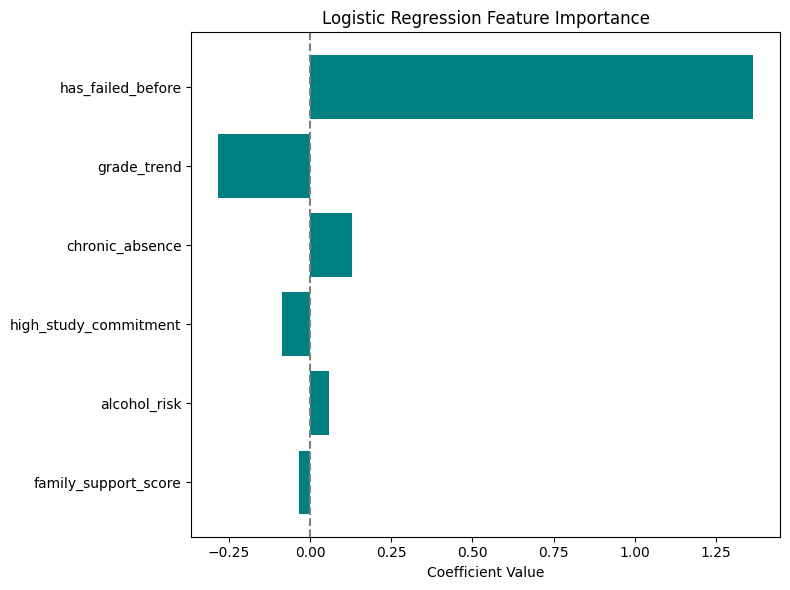

In [44]:
# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.barh(feature_importance['feature'], feature_importance['coefficient'], color='teal')
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Feature Importance")
plt.axvline(x=0, color='grey', linestyle='--')  # reference line at 0
plt.tight_layout()
plt.show()

**Random Forest Model**

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
# Train the model
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [37]:
# Make predictions
y_pred_rf = rf_model.predict(X_test)

In [38]:
# Evaluate Random Forest
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

Confusion Matrix (Random Forest):
[[45  8]
 [10 16]]

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.82      0.85      0.83        53
           1       0.67      0.62      0.64        26

    accuracy                           0.77        79
   macro avg       0.74      0.73      0.74        79
weighted avg       0.77      0.77      0.77        79



In [40]:
# Feature Importance
rf_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

rf_importance

,feature,importance
0,grade_trend,0.346886
3,alcohol_risk,0.268884
4,family_support_score,0.166580
1,has_failed_before,0.124360
2,chronic_absence,0.066270
5,high_study_commitment,0.027021


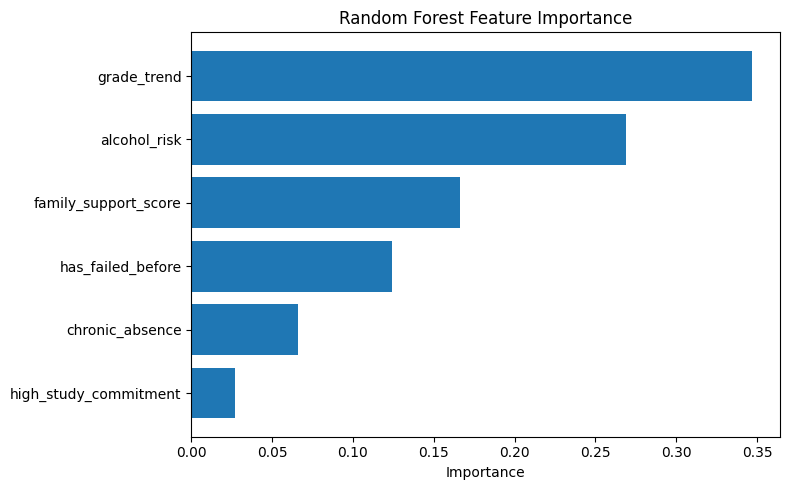

In [41]:
# Plot feature importance

plt.figure(figsize=(8,5))
plt.barh(rf_importance['feature'], rf_importance['importance'])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Compare with Logistic Regression**

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def model_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (At Risk)": precision_score(y_true, y_pred),
        "Recall (At Risk)": recall_score(y_true, y_pred),
        "F1-score (At Risk)": f1_score(y_true, y_pred)
    }

log_metrics = model_metrics(y_test, y_pred)
rf_metrics = model_metrics(y_test, y_pred_rf)

comparison_df = pd.DataFrame([log_metrics, rf_metrics],
                             index=["Logistic Regression", "Random Forest"])

comparison_df

,Accuracy,Precision (At Risk),Recall (At Risk),F1-score (At Risk)
Logistic Regression,0.746835,0.687500,0.423077,0.52381
Random Forest,0.772152,0.666667,0.615385,0.64000


Comparing the two models, Random Forest outperforms Logistic Regression in identifying at-risk students, particularly in terms of recall. While Logistic Regression has slightly higher precision, it misses a larger proportion of at-risk students. Given that the objective is to identify students needing intervention, Random Forest is the preferred model for actionable decision-making.

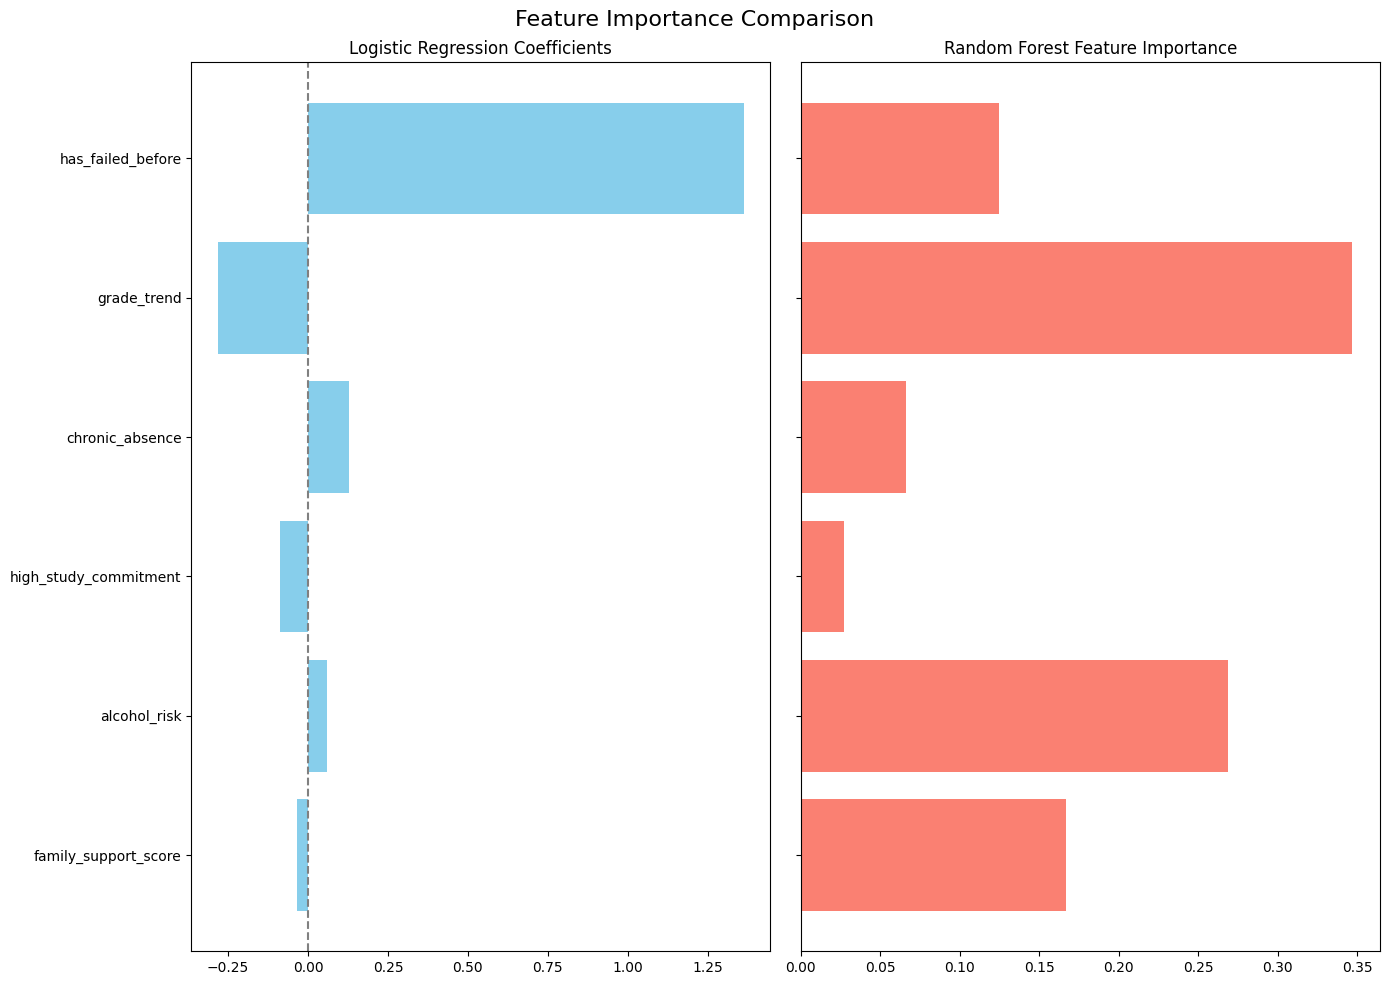

In [45]:
# Side-by-Side Feature Importance Plot

# --- Prepare Logistic Regression data ---
coef_df = pd.DataFrame({
    'feature': X.columns,
    'Logistic Regression': log_model.coef_[0]
})
coef_df['abs_coef'] = np.abs(coef_df['Logistic Regression'])
coef_df = coef_df.sort_values(by='abs_coef', ascending=True)

# --- Prepare Random Forest data ---
rf_df = pd.DataFrame({
    'feature': X.columns,
    'Random Forest': rf_model.feature_importances_
}).sort_values(by='Random Forest', ascending=True)

# --- Plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharey=True)

# Logistic Regression
axes[0].barh(coef_df['feature'], coef_df['Logistic Regression'], color='skyblue')
axes[0].set_title('Logistic Regression Coefficients')
axes[0].axvline(x=0, color='grey', linestyle='--')

# Random Forest
axes[1].barh(rf_df['feature'], rf_df['Random Forest'], color='salmon')
axes[1].set_title('Random Forest Feature Importance')

plt.suptitle("Feature Importance Comparison", fontsize=16)
plt.tight_layout()
plt.show()

# Save figure
fig.savefig("feature_importance_comparison.png", dpi=300, bbox_inches='tight')

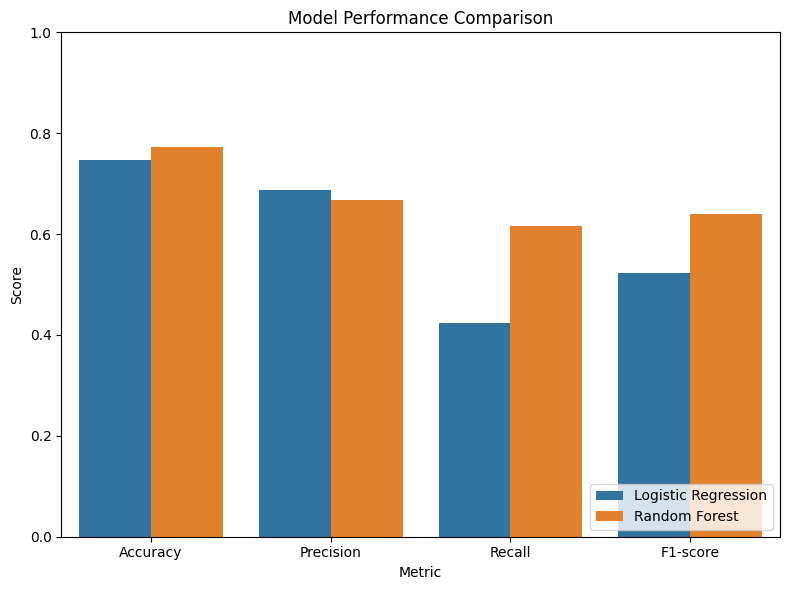

<Figure size 640x480 with 0 Axes>

In [46]:
# Metrics Comparison Plot
import seaborn as sns

# Metrics Data
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [0.746835, 0.772152],
    'Precision': [0.687500, 0.666667],
    'Recall': [0.423077, 0.615385],
    'F1-score': [0.52381, 0.64000]
})

# Melt for plotting
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(8,6))
sns.barplot(data=metrics_melted, x='Metric', y='Score', hue='Model')
plt.title("Model Performance Comparison")
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Save figure
plt.savefig("model_metrics_comparison.png", dpi=300, bbox_inches='tight')